In [1]:
import pandas as pd
import numpy as np
import os 
import time

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import confusion_matrix

from multiprocessing import Pool

import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import warnings 
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.rcParams[u'font.sans-serif'] = ['SimHei'] # 指定默认字体
matplotlib.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [2]:
def data_generate(data_type_filled):
    time_in = 3
    time_out = 6

    num_sample = data_type_filled['PM2.5'].shape[0] -time_in -time_out
    num_loc = data_type_filled['PM2.5'].shape[1] -3
    num_feature = len(data_type_filled)
    print('number of samples: '+str(num_sample))
    print('number of locations: '+str(num_loc))
    print('number of features: '+str(num_feature))
    
    data = []
    label = []
    data_filled_array = {}
    for type_now in data_type_filled:
        data_filled_array[type_now] = data_type_filled[type_now].iloc[:,3:].values
        
    start = time.time()
    for i in range(0,num_sample):
        data_now = np.zeros([time_in, num_feature, num_loc])
#         data_now = np.zeros([time_in, num_feature-1, num_loc]) #舍去PM2.5 or PCA
        feature_now = -1
        

        # 判断date是否连续
        if data_type_filled['PM2.5'].iloc[i+time_in+time_out-1,0] - data_type_filled['PM2.5'].iloc[i,0] < 2:
            # 判断hour是否连续
            if data_type_filled['PM2.5'].iloc[i+time_in+time_out-1,1] == (data_type_filled['PM2.5'].iloc[i,1] + time_in+time_out-1)%24: 
                for type_now in data_type_filled:
#                     if type_now == 'PCA': #选择只要PCA特征
#                     if type_now == 'PM2.5': #选择只要PM2.5特征
                    feature_now = feature_now +1
                    data_now[:,feature_now,:] = data_filled_array[type_now][i:i+time_in,:].copy()
                    if type_now == 'PM2.5':
                        label_now = data_filled_array[type_now][i+time_in:i+time_in+time_out,:].copy()
                        label_now[label_now < 35] = 1
                        label_now[label_now > 250] = 6
                        label_now[label_now > 150] = 5
                        label_now[label_now > 115] = 4
                        label_now[label_now > 75] = 3
                        label_now[label_now > 35] = 2
                        
                data_now = data_now.reshape((time_in*num_feature,num_loc))
#                 data_now = data_now.reshape((time_in*(num_feature-1),num_loc)) #舍去PM2.5 or PCA
                data.append(data_now)
                label.append(label_now)
        
    end = time.time()
#     print('data generating lasted: '+str(end-start))
           
    data = np.array(data)
    label = np.array(label)
    if label[label==0].shape[0]>0:
        print('there is a bug')
    return data, label

In [3]:
def data_split(filename):
    # 读取数据
    # filename = 'data_mix_clean_all.csv'
    data_all = pd.read_csv(filename)
    data_all = data_all.iloc[:,1:]
    # 划分数据集
    data_train = data_all[data_all['date'] < 20200000]
    data_train = data_train[data_train['date'] > 20150000]
    data_val = data_all[data_all['date'] > 20200000]
    data_test = data_all[data_all['date'] < 20150000]
    # 制作时序数据集
    list_type = np.unique(data_all['type']).tolist()
    data_train_type = {}
    data_val_type = {}
    data_test_type = {}
    for data_type in list_type:
        data_train_type[data_type] = data_train[data_train['type']==data_type]
        data_val_type[data_type] = data_val[data_val['type']==data_type]
        data_test_type[data_type] = data_test[data_test['type']==data_type]

    train_data,train_label = data_generate(data_train_type)
    val_data,val_label = data_generate(data_val_type)
    test_data,test_label = data_generate(data_test_type)
    
    return [train_data,train_label,val_data,val_label,test_data,test_label]

In [4]:
dataset_splited = data_split('data_mix_clean_all.csv')

number of samples: 10928
number of locations: 34
number of features: 6
number of samples: 1289
number of locations: 34
number of features: 6
number of samples: 1169
number of locations: 34
number of features: 6


In [5]:
dataset_splited_list = []
dataset_splited_list.append(dataset_splited)

In [6]:
# 检查数据格式
print(np.isnan(dataset_splited_list[0][0]).sum())
print(dataset_splited_list[0][0].shape)
print(dataset_splited_list[0][1].shape)
for i in range(8):
    item = dataset_splited_list[0][1][dataset_splited_list[0][1]==i].shape[0]
    num_all = dataset_splited_list[0][1].shape[0] * dataset_splited_list[0][1].shape[1] * dataset_splited_list[0][1].shape[2]
    print('ratio of '+str(i)+': '+str(item/num_all))


0
(4285, 18, 34)
(4285, 6, 34)
ratio of 0: 0.0
ratio of 1: 0.4045118630882925
ratio of 2: 0.265894479145217
ratio of 3: 0.13051341890315052
ratio of 4: 0.06476994531768367
ratio of 5: 0.09047177797606791
ratio of 6: 0.035458850984968086
ratio of 7: 0.0


In [7]:
def para_pass(args):
    return train_pre(*args)

def train_pre(train_data,train_label,val_data,val_label,test_data,test_label,loc, model_name):
    # 训练模型
    print(model_name+' '+loc)
    train_predict = np.zeros(train_label.shape)
    val_predict = np.zeros(val_label.shape)
    test_predict = np.zeros(test_label.shape)

    for ti in range(train_label.shape[1]):
        if model_name =='DT':
#             model = DecisionTreeRegressor(max_depth = 50)
            model = DecisionTreeClassifier(max_depth = 50)
#             model = DecisionTreeClassifier(max_depth = 50, class_weight='balanced')
        elif model_name =='RF':
#             model = RandomForestRegressor(n_estimators=50,max_depth = 50)
            model = RandomForestClassifier(n_estimators=50,max_depth = 50)
        elif model_name =='Ada_DT':
#             model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=50),n_estimators=50)
            model = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=50),n_estimators=50)
        elif model_name =='GBDT':
            model = GradientBoostingRegressor(n_estimators=10,max_depth = 50)

        lo = list_loc.tolist().index(loc)
        model.fit(train_data.reshape([train_data.shape[0],-1]), train_label[:,ti,lo])
        train_predict[:,ti,lo] = model.predict(train_data.reshape([train_data.shape[0],-1]))
        val_predict[:,ti,lo] = model.predict(val_data.reshape([val_data.shape[0],-1]))
        test_predict[:,ti,lo] = model.predict(test_data.reshape([test_data.shape[0],-1]))
            
    return [train_predict,val_predict,test_predict,loc]

In [28]:
models = ['RF','Ada_DT']
result_models = {}
list_loc = np.load("./data_mix_clean/location.npy",allow_pickle=True)

MultiNum = 17
pool = Pool(processes=MultiNum)

for model_name in models:
    start = time.time()
    para_list = []
    for loc in list_loc:
        train_data,train_label,val_data,val_label,test_data,test_label = dataset_splited_list[0]
        para_list.append([train_data,train_label,val_data,val_label,test_data,test_label,loc, model_name])
        
    result_pre_list = pool.map(para_pass,para_list)
    result_models[model_name] = result_pre_list

    end = time.time()
    print('training lasted: '+str(end-start))
pool.close() 
pool.join()

RF 东四
RF 天坛
RF 官园
RF 万寿西宫
RF 奥体中心
RF 农展馆
RF 万柳
RF 北部新区
RF 丰台花园
RF 云岗
RF 古城
RF 房山
RF 大兴
RF 亦庄
RF 通州
RF 顺义
RF 昌平
RF 门头沟
RF 平谷
RF 怀柔
RF 密云
RF 延庆
RF 定陵
RF 八达岭
RF 密云水库
RF 东高村
RF 永乐店
RF 榆垡
RF 琉璃河
RF 前门
RF 永定门内
RF 西直门北
RF 南三环
RF 东四环
Ada_DT 东四
Ada_DT 天坛
training lasted: 62.18775224685669
Ada_DT 官园
Ada_DT 万寿西宫
Ada_DT 奥体中心
Ada_DT 农展馆
Ada_DT 万柳
Ada_DT 北部新区
Ada_DT 丰台花园
Ada_DT 云岗
Ada_DT 古城
Ada_DT 房山
Ada_DT 大兴
Ada_DT 亦庄
Ada_DT 通州
Ada_DT 顺义
Ada_DT 昌平
Ada_DT 门头沟
Ada_DT 平谷
Ada_DT 怀柔
Ada_DT 密云
Ada_DT 延庆
Ada_DT 定陵
Ada_DT 八达岭
Ada_DT 密云水库
Ada_DT 东高村
Ada_DT 永乐店
Ada_DT 榆垡
Ada_DT 琉璃河
Ada_DT 前门
Ada_DT 永定门内
Ada_DT 西直门北
Ada_DT 南三环
Ada_DT 东四环
training lasted: 60.25192594528198


In [29]:
def Evaluation(label, predict):
    MAE = np.mean(np.abs(label - predict))
    RMSE = np.power(np.mean(np.power(label - predict,2)) ,0.5)

    label_grade = label.copy()
#     label_grade[label_grade < 35] = 1
#     label_grade[label_grade > 250] = 6
#     label_grade[label_grade > 150] = 5
#     label_grade[label_grade > 115] = 4
#     label_grade[label_grade > 75] = 3
#     label_grade[label_grade > 35] = 2
    
    predict_grade = predict.copy()
#     predict_grade[predict_grade < 35] = 1
#     predict_grade[predict_grade > 250] = 6
#     predict_grade[predict_grade > 150] = 5
#     predict_grade[predict_grade > 115] = 4
#     predict_grade[predict_grade > 75] = 3
#     predict_grade[predict_grade > 35] = 2
    
    res = np.zeros(label_grade.shape)
    res[label_grade == predict_grade] = 1
    num_cor = res.sum()
    num_all = res.shape[0] 
    prec = num_cor/num_all
    return MAE,RMSE,prec

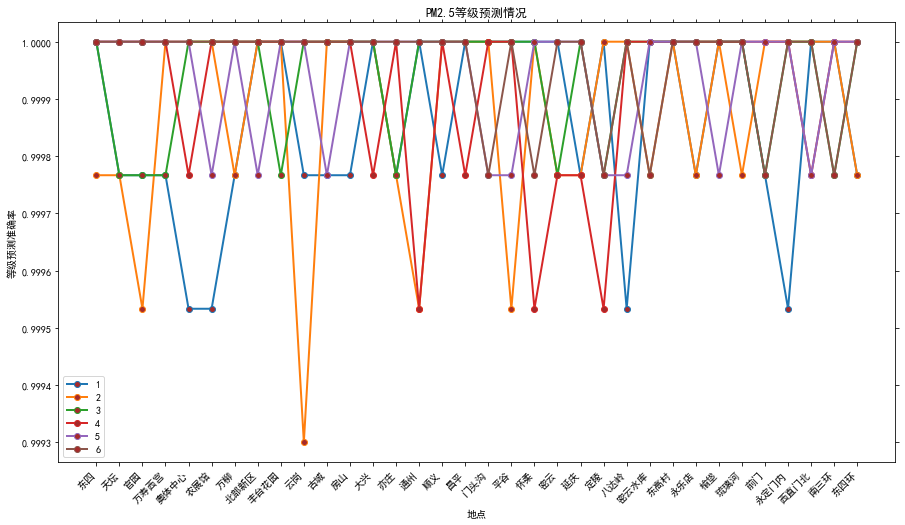

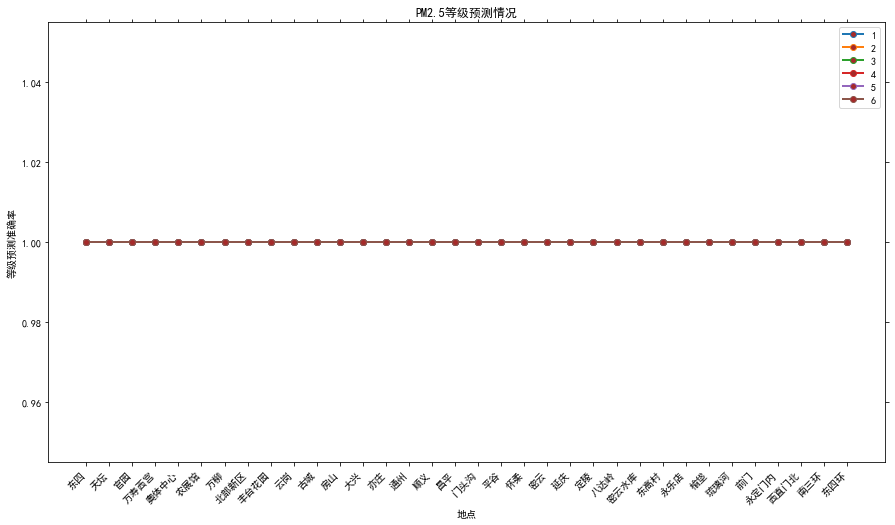

In [32]:
for model_name in models:
#     MAE = np.zeros([3,list_loc.shape[0],6])
#     RMSE = np.zeros([3,list_loc.shape[0],6])
#     PREC = np.zeros([3,list_loc.shape[0],6])
#     for ti in range(6):
#         for train_predict,val_predict,test_predict,loc_pre in result_models[model_name]:
#             idx_loc = list_loc.tolist().index(loc_pre)
#             for _,train_label,_,val_label,_,test_label in dataset_splited_list:
#                 MAE[0,idx_loc,ti], RMSE[0,idx_loc,ti],PREC[0,idx_loc,ti]= Evaluation(train_label[:,ti,loc_pre],train_predict[:,ti,:])
#                 MAE[1,idx_loc,ti], RMSE[1,idx_loc,ti],PREC[1,idx_loc,ti]= Evaluation(val_label[:,ti,loc_pre],val_predict[:,ti,:])
#                 MAE[2,idx_loc,ti], RMSE[2,idx_loc,ti],PREC[2,idx_loc,ti]= Evaluation(test_label[:,ti,loc_pre],test_predict[:,ti,:])
    for ti in range(6):
        for train_predict,val_predict,test_predict,loc_pre in result_models[model_name]:
            idx_loc = list_loc.tolist().index(loc_pre)
            for _,train_label,_,val_label,_,test_label in dataset_splited_list:
                MAE[0,idx_loc,ti], RMSE[0,idx_loc,ti],PREC[0,idx_loc,ti]= Evaluation(train_label[:,ti,idx_loc],train_predict[:,ti,idx_loc])
                MAE[1,idx_loc,ti], RMSE[1,idx_loc,ti],PREC[1,idx_loc,ti]= Evaluation(val_label[:,ti,idx_loc],val_predict[:,ti,idx_loc])
                MAE[2,idx_loc,ti], RMSE[2,idx_loc,ti],PREC[2,idx_loc,ti]= Evaluation(test_label[:,ti,idx_loc],test_predict[:,ti,idx_loc])
    

    fig = plt.figure(figsize = (15,9))
    plt.plot(list_loc, # x轴数据
             PREC[0,:,:], # y轴数据
             linestyle = '-', # 折线类型
             linewidth = 2, # 折线宽度
    #          color = 'steelblue', # 折线颜色
             marker = 'o', # 点的形状
             markersize = 6, # 点的大小
    #          markeredgecolor='black', # 点的边框色
             markerfacecolor='brown') # 点的填充色
    plt.title('PM2.5等级预测情况')
    plt.xlabel('地点')
    plt.ylabel('等级预测准确率')
    plt.tick_params(top = 'off', right = 'off')
    fig.autofmt_xdate(rotation = 45)
    # 设置图例
    plt.legend([1,2,3,4,5,6])
    # 显示图形
    plt.show()

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    # plt.savefig('confusion_matrix',dpi=200)


[[1263  205   13    4    2    0]
 [ 244  895  190   24    5    0]
 [  21  237  576  123   25    0]
 [   2   17  126  287   74    3]
 [   1    5   31   77  384   36]
 [   0    1    0    6   38  209]]


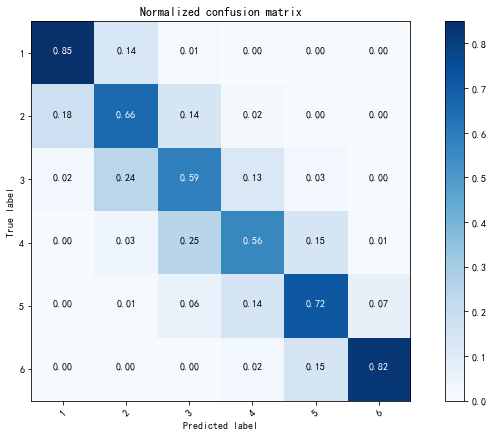

In [23]:
y_true = test_label[:,0,0]
y_pred = test_predict[:,0,0]
cnf_matrix = confusion_matrix(y_true, y_pred, labels=[1,2,3,4,5,6])

class_names = [1,2,3,4,5,6]
 
# plt.figure(figsize = (10,6))
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Confusion matrix, without normalization')
 
# Plot normalized confusion matrix
plt.figure(figsize = (10,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')




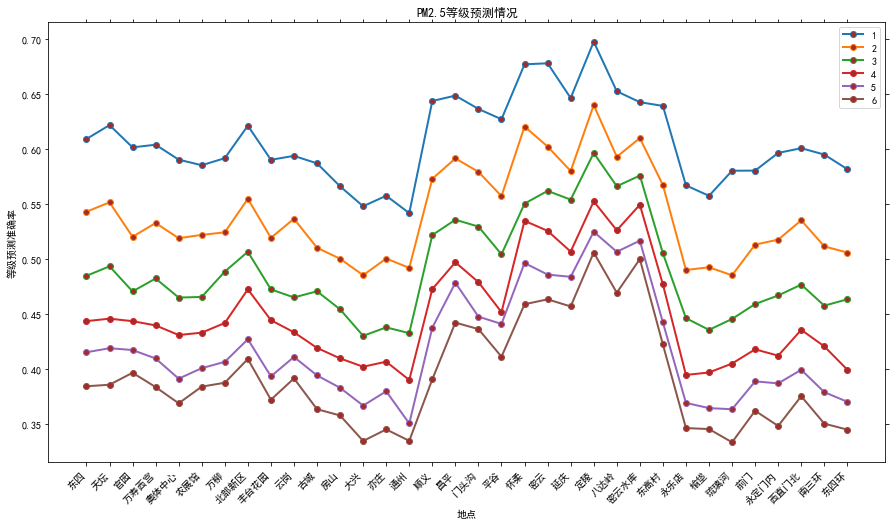

In [10]:
# 以下是PCA，input:12 分类树DT测试结果

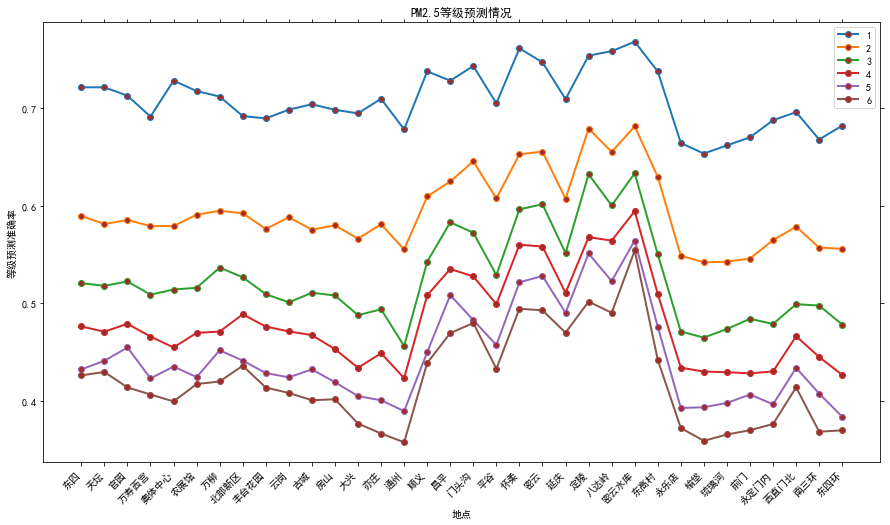

In [10]:
# 以下是六特征，input:12 分类树DT测试结果

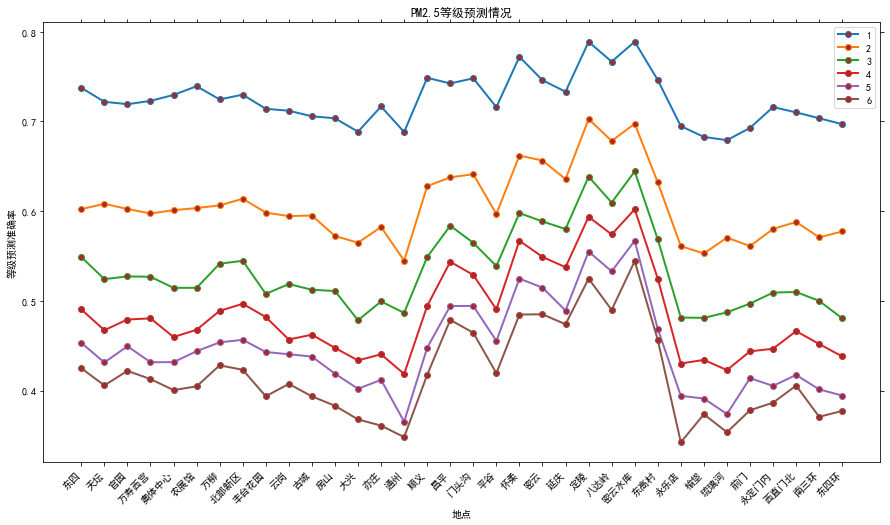

In [19]:
# 以下是PM2.5特征，input:12 分类树DT测试结果

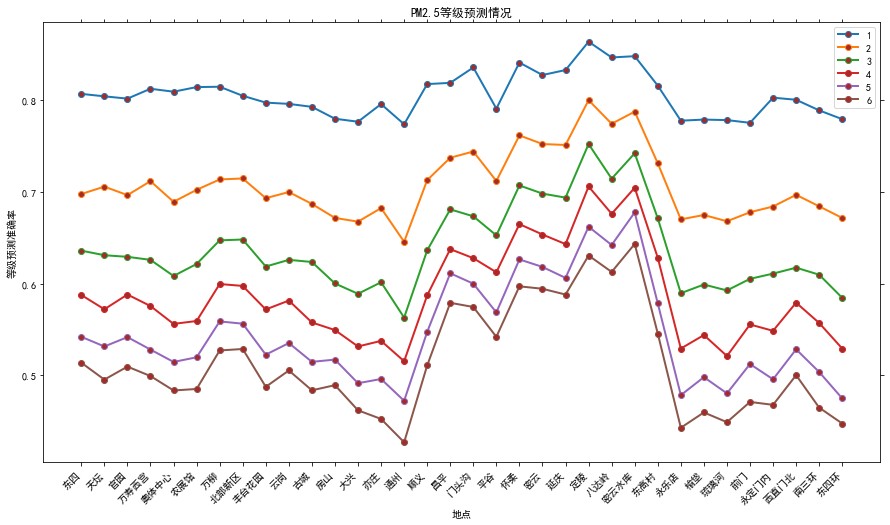

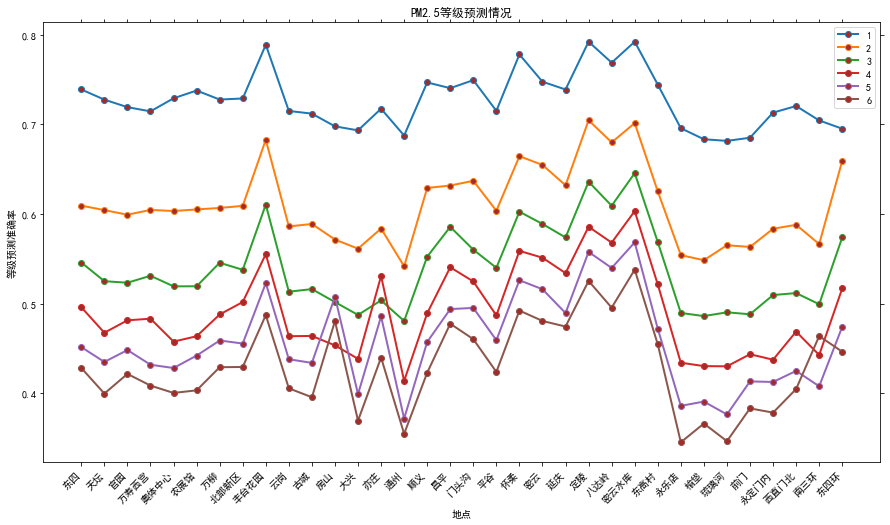

In [16]:
# 以下是PM2.5特征，input:12 分类树RF, Ada_DT测试结果

In [11]:
# PM2.5 input:18 PREC[2,:,0]

array([0.77777778, 0.77631816, 0.78395484, 0.77619532, 0.78240904,
       0.80629787, 0.78096179, 0.75226337, 0.77203799, 0.76550226,
       0.76944396, 0.75507488, 0.72530002, 0.75528106, 0.75442718,
       0.81854329, 0.77827979, 0.79722675, 0.75815674, 0.83611691,
       0.8038733 , 0.78714794, 0.83495471, 0.79096796, 0.82962448,
       0.77834966, 0.74232287, 0.74053348, 0.73600283, 0.75689393,
       0.74861518, 0.74741201, 0.76656368, 0.749612  ])

In [12]:
# PM2.5 input:6 PREC[2,:,0]

array([0.74975174, 0.75004489, 0.75554797, 0.73857868, 0.74797321,
       0.775947  , 0.75558843, 0.73353047, 0.7507068 , 0.73477898,
       0.74675886, 0.72002657, 0.71058244, 0.73347624, 0.71276596,
       0.77817854, 0.76085504, 0.77906219, 0.73682444, 0.80295139,
       0.77493857, 0.76736672, 0.8151992 , 0.7907208 , 0.81627342,
       0.75990058, 0.71340524, 0.71580123, 0.72153465, 0.72007429,
       0.73739837, 0.73840376, 0.74871531, 0.72586474])

In [11]:
# 6特征 PREC[2,:,0]

array([0.76491054, 0.75930253, 0.75871497, 0.74796748, 0.76587862,
       0.77860908, 0.75847318, 0.74592995, 0.75245547, 0.74219402,
       0.75324451, 0.74102394, 0.731483  , 0.7566166 , 0.73032491,
       0.80357465, 0.76546306, 0.78992829, 0.75134409, 0.81612791,
       0.79734383, 0.75727684, 0.81434316, 0.79217117, 0.80427232,
       0.76198375, 0.72887746, 0.71846469, 0.70707965, 0.73635288,
       0.73486328, 0.74130476, 0.74759945, 0.73540052])

In [11]:
# PM2.5 PREC[2,:,0]

array([0.76474486, 0.76721194, 0.76503759, 0.75762195, 0.77081863,
       0.79272233, 0.76768674, 0.75102779, 0.76161145, 0.75304725,
       0.75930092, 0.7450133 , 0.72672032, 0.74642346, 0.73032491,
       0.79942228, 0.77281846, 0.78911343, 0.75386425, 0.81543274,
       0.79324479, 0.77829884, 0.82841823, 0.79183944, 0.82250782,
       0.77757505, 0.73916024, 0.73709707, 0.73238938, 0.73973297,
       0.7516276 , 0.74243279, 0.7601166 , 0.7419466 ])

In [16]:
# PCA PREC[2,:,0]

array([0.64943671, 0.67697286, 0.65601504, 0.64803523, 0.64643613,
       0.67148444, 0.63392563, 0.65170202, 0.64541368, 0.65419937,
       0.65028552, 0.63347739, 0.60141238, 0.62178112, 0.61155235,
       0.71799964, 0.68973587, 0.68138853, 0.66229839, 0.73270768,
       0.71372356, 0.69259379, 0.73424933, 0.68751037, 0.68878083,
       0.67142146, 0.62570694, 0.62418483, 0.63575221, 0.65861078,
       0.63688151, 0.64166197, 0.66683813, 0.62170543])

In [24]:
a = pd.DataFrame()

In [25]:
a['ok']=1

In [27]:
b = a

In [29]:
b['okok']=1

In [38]:
c= b.iloc[:,0:1]

In [36]:
b['okokok']=1

In [40]:
c['buok']=1

In [45]:
b.drop(['ok'],axis=1)

,okok,okokok


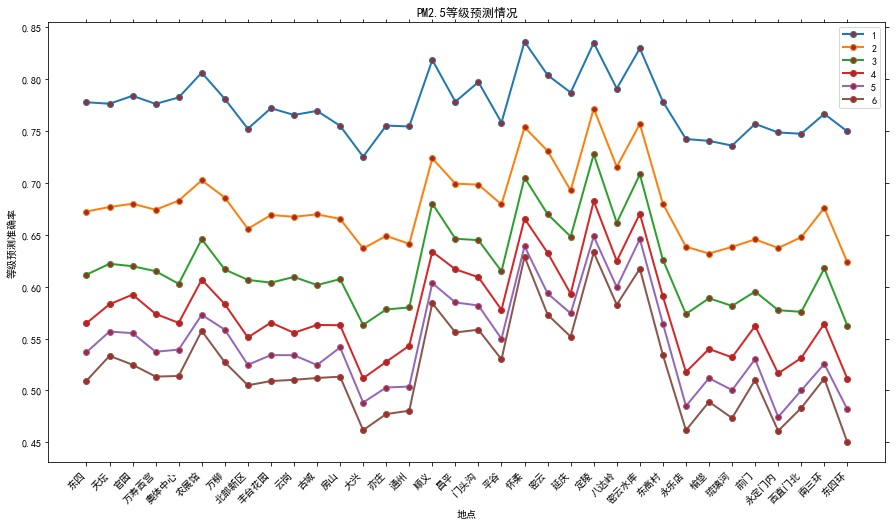

In [10]:
# PM2.5 input:18 决策树

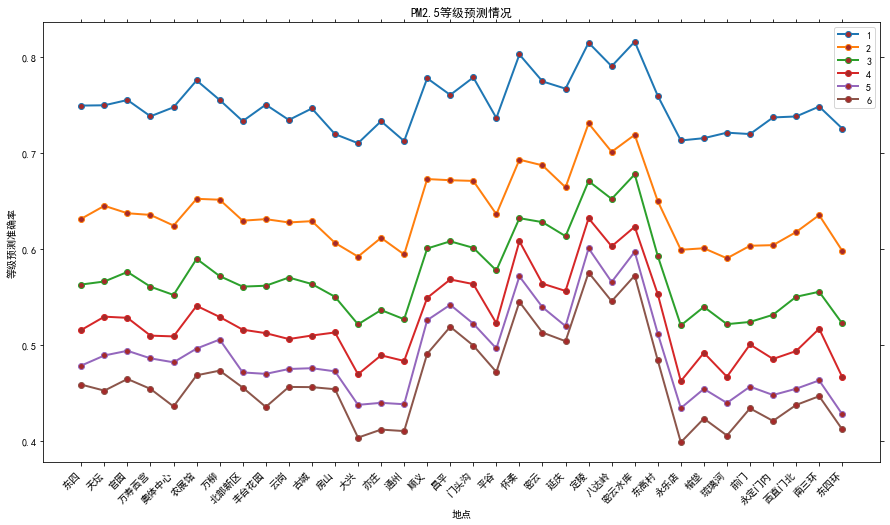

In [10]:
# PM2.5特征 input:6小时，决策树结果

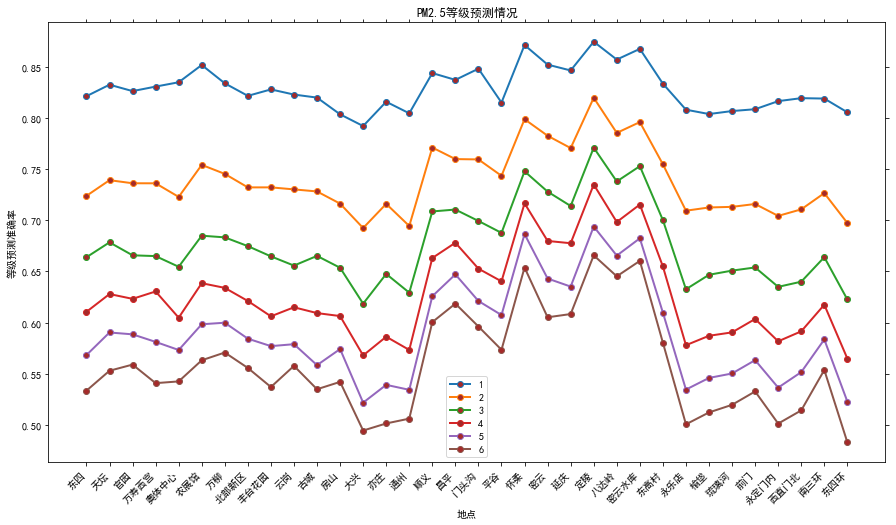

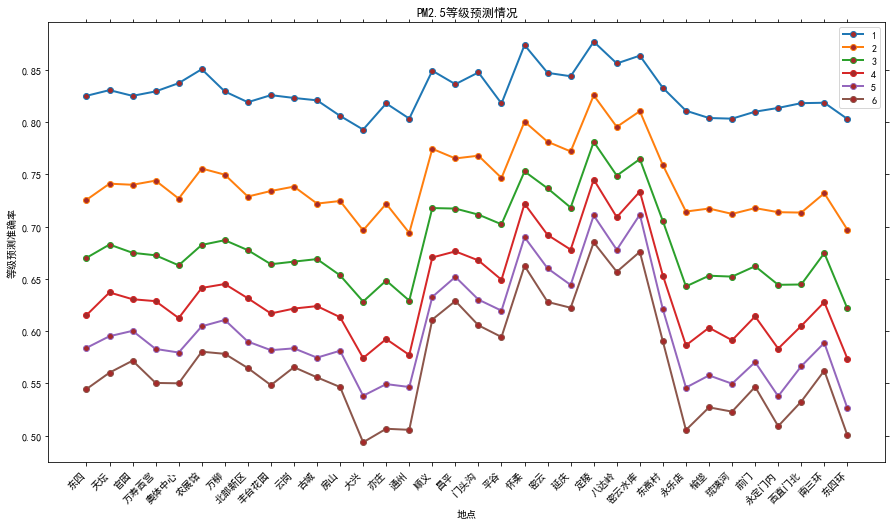

In [9]:
# 以下是PM2.5特征，RF, Ada_DT测试结果

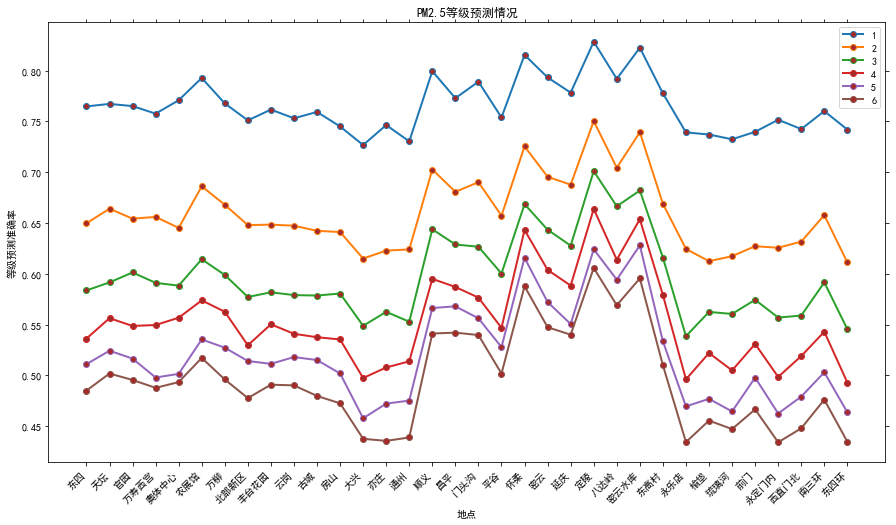

In [13]:
# 以下是PM2.5特征，决策树测试结果

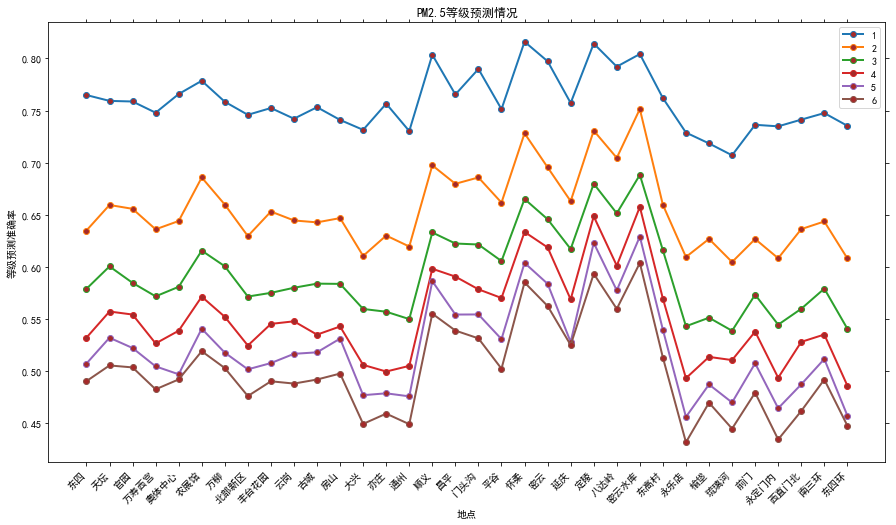

In [10]:
# 以下是6特征，决策树测试结果

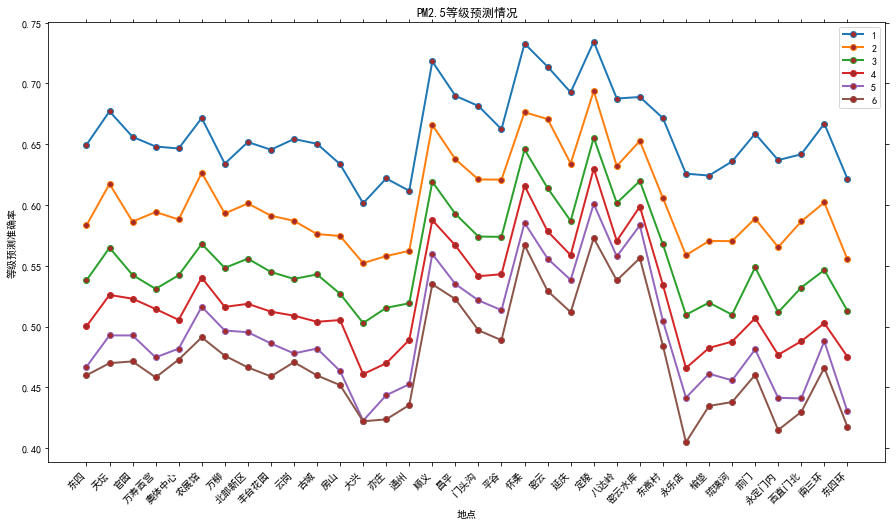

In [15]:
# 以下是PCA特征，决策树测试结果